# Filtering and trimming messages

## Review

By now, we have a deeper understanding of things: 

* How to define various state schemas
* How to define custom state reducers
* How to use multiple states within your graph

## Goals

Now, we can start using these concepts with LLMs in LangGraph.

In the next few sessions, we'll build towards a chatbot that has long-term memory!

Let's first talk a bit more about advanced ways to work with messages in graph state.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

[LangSmith](https://docs.smith.langchain.com/) gives us [tracing](https://docs.smith.langchain.com/concepts/tracing).

Ensure these enviorment variables are set:

```
export LANGCHAIN_API_KEY="xxx"
export LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
export LANGCHAIN_TRACING_V2=true
```

Ad then set our `LANGCHAIN_PROJECT`.

In [28]:
import os
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [2]:
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

from pprint import pprint
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='There are several fascinating ocean mammals besides whales that you might find interesting. Here are a few to consider:\n\n1. **Dolphins**: These highly intelligent and social animals are known for their playful behavior. There are several species of dolphins, including the well-known bottlenose dolphin.\n\n2. **Porpoises**: Similar to dolphins but generally smaller and with different shaped teeth and fins, porpoises are another group of small cetaceans.\n\n3. **Seals**: These are pinnipeds, a group that also includes sea lions and walruses. They are adapted to life both in the water and on land.\n\n4. **Sea Lions**: Often confused with seals, sea lions have external ear flaps and can "walk" on land using their large flippers. They are also quite social and often seen in groups.\n\n5. **Walruses**: Known for their distinctive tusks and whiskers, walruses are large pinnipeds that live in Arctic regions.\n\n6. **Manatees**: Also known as sea cows, manatees are gentle h

We can use this in a simple graph with `MessagesState`.

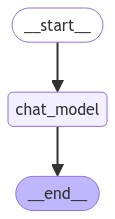

In [4]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are several fascinating ocean mammals beyond whales that are worth learning about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals known for their playful behavior and complex communication skills. Species include the bottlenose dolphin and the Orca or killer whale (which is actually a type of dolphin).

2. **Seals and Sea Lions**: Pinnipeds that are found in various parts of the world. Seals are more adapted to an aquatic lifestyle, while sea lions are more agile on land.

3. **Manatees and Dugongs**: Often referred to as sea cows, these gentle herbivores graze on underwater vegetat

## Reducer

A practical challenge when working with messages is managining long-running conversations!

This results in high token usage and latency if we are not careful.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

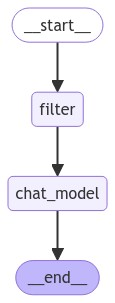

In [6]:
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from langchain_core.messages import RemoveMessage

from langgraph.graph.message import add_messages
        
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build grapph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id=1)]
messages.append(HumanMessage("Hi.", name="Lance", id=2))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id=3))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id=4))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

/Users/rlm/miniforge3/envs/llama2/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals! Besides whales, there are several other fascinating marine mammals you might want to explore:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and complex communication skills.

2. **Porpoises**: Similar to dolphins but generally smaller and with different facial structures and fin shapes. They're less well-known but equally interesting.

3. **Seals**: These come in various species, such as harbor seals and elephant seals. They are known for their adaptability to both land and sea.

4. **Sea Lions**: Often confu

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

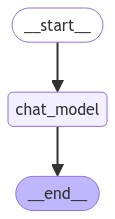

In [8]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build grapph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [9]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [10]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals! Besides whales, there are several other fascinating marine mammals you might want to explore:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and complex communication skills.

2. **Porpoises**: Similar to dolphins but generally smaller and with different facial structures and fin shapes. They're less well-known but equa

In [11]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals! Besides whales, there are several other fascinating marine mammals you might want to explore:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and complex communication skills.

2. **Porpoises**: Similar to dolphins but generally smaller and with different facial structures and fin shapes. They're less well-known but equa

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

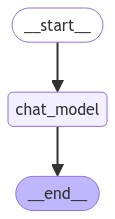

In [25]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build grapph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [21]:
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', name='Lance')]

In [29]:
# Invoke, using message trimming
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r